In [1]:
# 01-synthetic-data-generation.ipynb
# Openbook ML Demo - Synthetic Data Generation
# Creates HIPAA-compliant synthetic data mimicking real dental insurance patterns

"""
This notebook generates synthetic data for:
1. Patients
2. Insurance plans (with coverage details)
3. Dental procedures (10 common codes)
4. Historical claims with copays (training data)
5. Dental office (with network affiliations)

Production Note: Real Openbook uses actual patient data under HIPAA compliance.
This synthetic dataset demonstrates the ML pipeline without privacy concerns.
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import json
from google.cloud import storage

# Configuration
PROJECT_ID = "openbook-ml-demo"
REGION = "us-central1"
BUCKET_NAME = "openbook-data-lake"

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")
print("\n✓ Configuration set")

Project: openbook-ml-demo
Region: us-central1
Bucket: openbook-data-lake

✓ Configuration set


In [2]:
# Create GCS bucket and data lake structure

def create_bucket_if_not_exists(bucket_name, project_id, region):
    """Create GCS bucket with proper structure for ML data lake"""
    client = storage.Client(project=project_id)
    
    try:
        bucket = client.get_bucket(bucket_name)
        print(f"✓ Bucket '{bucket_name}' already exists")
    except:
        bucket = client.create_bucket(bucket_name, location=region)
        print(f"✓ Created bucket '{bucket_name}' in {region}")
    
    return bucket

# Create bucket
bucket = create_bucket_if_not_exists(BUCKET_NAME, PROJECT_ID, REGION)

# Define data lake structure
folders = [
    "raw/patients/",
    "raw/insurance_plans/",
    "raw/procedures/",
    "raw/claims/",
    "raw/dental_office/",
    "processed/features/",
    "models/",
    "figures/",
    "pipeline/"
]

# Create folder placeholders
for folder in folders:
    blob = bucket.blob(folder + ".keep")
    blob.upload_from_string("")
    
print("\n✓ Data lake structure created:")
for folder in folders:
    print(f"  gs://{BUCKET_NAME}/{folder}")

✓ Created bucket 'openbook-data-lake' in us-central1

✓ Data lake structure created:
  gs://openbook-data-lake/raw/patients/
  gs://openbook-data-lake/raw/insurance_plans/
  gs://openbook-data-lake/raw/procedures/
  gs://openbook-data-lake/raw/claims/
  gs://openbook-data-lake/raw/dental_office/
  gs://openbook-data-lake/processed/features/
  gs://openbook-data-lake/models/
  gs://openbook-data-lake/figures/
  gs://openbook-data-lake/pipeline/


In [3]:
# Define insurance plans with coverage details
# These mirror real plan structures parsed from Stedi API in production

INSURANCE_PLANS = pd.DataFrame([
    {
        "plan_id": "DELTA_PPO_GOLD",
        "carrier": "Delta Dental",
        "plan_type": "PPO",
        "annual_maximum": 2000,
        "deductible": 50,
        "preventive_coverage": 100,  # percentage
        "basic_coverage": 80,
        "major_coverage": 50,
        "waiting_period_basic": 0,  # months
        "waiting_period_major": 12,
    },
    {
        "plan_id": "DELTA_PPO_SILVER",
        "carrier": "Delta Dental",
        "plan_type": "PPO",
        "annual_maximum": 1500,
        "deductible": 75,
        "preventive_coverage": 100,
        "basic_coverage": 70,
        "major_coverage": 50,
        "waiting_period_basic": 6,
        "waiting_period_major": 12,
    },
    {
        "plan_id": "CIGNA_DHMO",
        "carrier": "Cigna",
        "plan_type": "DHMO",
        "annual_maximum": 0,  # No max for DHMO (copay-based)
        "deductible": 0,
        "preventive_coverage": 100,
        "basic_coverage": 100,  # Fixed copays instead
        "major_coverage": 100,
        "waiting_period_basic": 0,
        "waiting_period_major": 0,
    },
    {
        "plan_id": "AETNA_PPO_BASIC",
        "carrier": "Aetna",
        "plan_type": "PPO",
        "annual_maximum": 1000,
        "deductible": 100,
        "preventive_coverage": 100,
        "basic_coverage": 60,
        "major_coverage": 40,
        "waiting_period_basic": 0,
        "waiting_period_major": 12,
    },
    {
        "plan_id": "METLIFE_PPO_PREMIUM",
        "carrier": "MetLife",
        "plan_type": "PPO",
        "annual_maximum": 2500,
        "deductible": 25,
        "preventive_coverage": 100,
        "basic_coverage": 80,
        "major_coverage": 60,
        "waiting_period_basic": 0,
        "waiting_period_major": 6,
    },
    {
        "plan_id": "GUARDIAN_INDEMNITY",
        "carrier": "Guardian",
        "plan_type": "Indemnity",
        "annual_maximum": 1500,
        "deductible": 50,
        "preventive_coverage": 80,
        "basic_coverage": 80,
        "major_coverage": 50,
        "waiting_period_basic": 0,
        "waiting_period_major": 12,
    },
])

print("Insurance Plans:")
print("=" * 100)
print(INSURANCE_PLANS.to_string(index=False))
print(f"\n✓ {len(INSURANCE_PLANS)} insurance plans defined")
print("\n✓ Production Note: Real Openbook parses plan details from Stedi API JSON responses")

Insurance Plans:
            plan_id      carrier plan_type  annual_maximum  deductible  preventive_coverage  basic_coverage  major_coverage  waiting_period_basic  waiting_period_major
     DELTA_PPO_GOLD Delta Dental       PPO            2000          50                  100              80              50                     0                    12
   DELTA_PPO_SILVER Delta Dental       PPO            1500          75                  100              70              50                     6                    12
         CIGNA_DHMO        Cigna      DHMO               0           0                  100             100             100                     0                     0
    AETNA_PPO_BASIC        Aetna       PPO            1000         100                  100              60              40                     0                    12
METLIFE_PPO_PREMIUM      MetLife       PPO            2500          25                  100              80              60                    

In [4]:
# Define the dental office (demo uses one office)
# In-network status affects coverage percentages and allowed amounts

DENTAL_OFFICE = {
    "office_id": "AVALON_001",
    "name": "Avalon Dental",
    "location": "Wilmington, DE",
    "in_network_carriers": ["Delta Dental", "MetLife", "Guardian"],
    "out_of_network_carriers": ["Cigna", "Aetna"],  # Still accepts, lower coverage
}

# Out-of-network typically means:
# - 10-20% lower coverage percentages
# - Balance billing (patient pays difference between charged and allowed)
# - Higher effective copays

print("Dental Office Configuration:")
print("=" * 60)
print(f"  Office: {DENTAL_OFFICE['name']}")
print(f"  Location: {DENTAL_OFFICE['location']}")
print(f"\n  In-Network With:")
for carrier in DENTAL_OFFICE['in_network_carriers']:
    print(f"    ✓ {carrier}")
print(f"\n  Out-of-Network (accepts, reduced benefits):")
for carrier in DENTAL_OFFICE['out_of_network_carriers']:
    print(f"    ○ {carrier}")

print("\n✓ Production Note: Real Openbook pulls network status from Stedi API eligibility checks")

Dental Office Configuration:
  Office: Avalon Dental
  Location: Wilmington, DE

  In-Network With:
    ✓ Delta Dental
    ✓ MetLife
    ✓ Guardian

  Out-of-Network (accepts, reduced benefits):
    ○ Cigna
    ○ Aetna

✓ Production Note: Real Openbook pulls network status from Stedi API eligibility checks


In [5]:
# Generate synthetic patients
# Production: Real patient data under HIPAA compliance

NUM_PATIENTS = 1000  # Training data size

# Name pools for realistic synthetic data
FIRST_NAMES = ["James", "Mary", "John", "Patricia", "Robert", "Jennifer", "Michael", "Linda", 
               "William", "Elizabeth", "David", "Barbara", "Richard", "Susan", "Joseph", "Jessica",
               "Thomas", "Sarah", "Christopher", "Karen", "Daniel", "Nancy", "Matthew", "Lisa"]

LAST_NAMES = ["Smith", "Johnson", "Williams", "Brown", "Jones", "Garcia", "Miller", "Davis",
              "Rodriguez", "Martinez", "Hernandez", "Lopez", "Gonzalez", "Wilson", "Anderson",
              "Thomas", "Taylor", "Moore", "Jackson", "Martin", "Lee", "Perez", "Thompson"]

def generate_patients(n):
    patients = []
    for i in range(n):
        # Assign insurance plan
        plan = INSURANCE_PLANS.sample(1).iloc[0]
        
        # Determine network status based on office affiliations
        is_in_network = plan['carrier'] in DENTAL_OFFICE['in_network_carriers']
        
        # Generate year-to-date insurance usage (realistic distribution)
        # Most patients use some benefits, few max out
        max_amount = plan['annual_maximum'] if plan['annual_maximum'] > 0 else 2000
        ytd_usage = np.random.exponential(scale=400)  # Skewed toward lower usage
        ytd_usage = min(ytd_usage, max_amount * 0.95)  # Cap at 95% of max
        
        # Deductible status (70% have met it by mid-year)
        deductible_met = random.random() < 0.7
        deductible_remaining = 0 if deductible_met else plan['deductible']
        
        # Months since plan started (affects waiting periods)
        months_enrolled = random.choices(
            [3, 6, 12, 24, 36, 48],
            weights=[0.1, 0.15, 0.25, 0.2, 0.15, 0.15]
        )[0]
        
        patients.append({
            "patient_id": f"PAT_{i+1:04d}",
            "first_name": random.choice(FIRST_NAMES),
            "last_name": random.choice(LAST_NAMES),
            "plan_id": plan['plan_id'],
            "carrier": plan['carrier'],
            "plan_type": plan['plan_type'],
            "is_in_network": is_in_network,
            "annual_maximum": plan['annual_maximum'],
            "ytd_usage": round(ytd_usage, 2),
            "remaining_maximum": max(0, plan['annual_maximum'] - ytd_usage) if plan['annual_maximum'] > 0 else 999999,
            "deductible": plan['deductible'],
            "deductible_remaining": deductible_remaining,
            "preventive_coverage": plan['preventive_coverage'],
            "basic_coverage": plan['basic_coverage'],
            "major_coverage": plan['major_coverage'],
            "waiting_period_basic": plan['waiting_period_basic'],
            "waiting_period_major": plan['waiting_period_major'],
            "months_enrolled": months_enrolled,
        })
    
    return pd.DataFrame(patients)

patients_df = generate_patients(NUM_PATIENTS)

print(f"Generated {len(patients_df)} synthetic patients")
print("=" * 80)
print(patients_df.head(10).to_string(index=False))
print(f"\nNetwork distribution:")
print(patients_df['is_in_network'].value_counts())
print(f"\nPlan distribution:")
print(patients_df['plan_id'].value_counts())

Generated 1000 synthetic patients
patient_id  first_name last_name             plan_id      carrier plan_type  is_in_network  annual_maximum  ytd_usage  remaining_maximum  deductible  deductible_remaining  preventive_coverage  basic_coverage  major_coverage  waiting_period_basic  waiting_period_major  months_enrolled
  PAT_0001      Thomas    Martin      DELTA_PPO_GOLD Delta Dental       PPO           True            2000     365.18        1634.822978          50                     0                  100              80              50                     0                    12                6
  PAT_0002      Daniel  Thompson  GUARDIAN_INDEMNITY     Guardian Indemnity           True            1500     804.49         695.507654          50                     0                   80              80              50                     0                    12                6
  PAT_0003 Christopher Rodriguez METLIFE_PPO_PREMIUM      MetLife       PPO           True            2500     

In [7]:
# Define dental procedures (CDT codes)
PROCEDURES = pd.DataFrame([
    {"code": "D0120", "description": "Periodic oral evaluation", "category": "preventive", "avg_cost": 65, "frequency_limit": "2 per year"},
    {"code": "D0274", "description": "Bitewings - four films", "category": "preventive", "avg_cost": 80, "frequency_limit": "2 per year"},
    {"code": "D1110", "description": "Prophylaxis - adult cleaning", "category": "preventive", "avg_cost": 130, "frequency_limit": "2 per year"},
    {"code": "D2391", "description": "Resin filling - one surface", "category": "basic", "avg_cost": 195, "frequency_limit": "none"},
    {"code": "D2392", "description": "Resin filling - two surfaces", "category": "basic", "avg_cost": 250, "frequency_limit": "none"},
    {"code": "D2750", "description": "Crown - porcelain fused to metal", "category": "major", "avg_cost": 1200, "frequency_limit": "1 per 5 years"},
    {"code": "D2950", "description": "Core buildup including pins", "category": "major", "avg_cost": 385, "frequency_limit": "none"},
    {"code": "D3310", "description": "Root canal - anterior tooth", "category": "major", "avg_cost": 950, "frequency_limit": "none"},
    {"code": "D7140", "description": "Extraction - erupted tooth", "category": "basic", "avg_cost": 220, "frequency_limit": "none"},
    {"code": "D5110", "description": "Complete denture - maxillary", "category": "major", "avg_cost": 1800, "frequency_limit": "1 per 5 years"},
])

In [8]:
# Generate historical claims with ACTUAL copays paid
# This is where the model learns patterns between expected vs actual payments

NUM_CLAIMS = 10000  # Historical claims for training

def calculate_actual_copay(patient, procedure, claim_date):
    """
    Simulate what insurance ACTUALLY paid (not just the formula).
    Includes real-world patterns: denials, underpayments, network adjustments, etc.
    """
    
    base_cost = procedure['avg_cost']
    category = procedure['category']
    
    # Get coverage percentage based on category
    if category == 'preventive':
        coverage_pct = patient['preventive_coverage'] / 100
    elif category == 'basic':
        coverage_pct = patient['basic_coverage'] / 100
    else:  # major
        coverage_pct = patient['major_coverage'] / 100
    
    # === REAL-WORLD ADJUSTMENTS (what the model learns) ===
    
    # 1. Out-of-network penalty (varies by carrier)
    if not patient['is_in_network']:
        oon_penalties = {
            'Cigna': 0.25,      # Cigna is harsh on OON
            'Aetna': 0.18,      # Aetna slightly better
        }
        penalty = oon_penalties.get(patient['carrier'], 0.15)
        coverage_pct = max(0, coverage_pct - penalty)
        # Also: OON means higher allowed amount gap
        base_cost = base_cost * random.uniform(1.1, 1.25)  # Balance billing
    
    # 2. Waiting period denials
    if category == 'major' and patient['months_enrolled'] < patient['waiting_period_major']:
        # Full denial - patient pays everything
        return base_cost, 0, base_cost, "DENIED_WAITING_PERIOD"
    if category == 'basic' and patient['months_enrolled'] < patient['waiting_period_basic']:
        return base_cost, 0, base_cost, "DENIED_WAITING_PERIOD"
    
    # 3. Apply deductible first (if not met)
    deductible_applied = min(patient['deductible_remaining'], base_cost)
    after_deductible = base_cost - deductible_applied
    
    # 4. Calculate insurance portion
    insurance_pays = after_deductible * coverage_pct
    
    # 5. Annual maximum cap
    if patient['annual_maximum'] > 0:
        available_max = patient['remaining_maximum']
        if insurance_pays > available_max:
            insurance_pays = available_max
            status = "MAX_EXHAUSTED" if available_max == 0 else "MAX_PARTIAL"
        else:
            status = "PAID"
    else:
        status = "PAID"  # DHMO has no max
    
    # 6. Random carrier behavior (underpayments, processing quirks)
    # Some carriers consistently underpay by small amounts
    carrier_quirks = {
        'Aetna': lambda x: x * random.uniform(0.92, 1.0),      # Often underpays
        'Cigna': lambda x: x * random.uniform(0.95, 1.0),      # Slightly underpays
        'Delta Dental': lambda x: x * random.uniform(0.98, 1.02),  # Mostly accurate
        'MetLife': lambda x: x * random.uniform(0.97, 1.01),   # Slightly under
        'Guardian': lambda x: x * random.uniform(0.96, 1.0),   # Underpays
    }
    quirk_fn = carrier_quirks.get(patient['carrier'], lambda x: x)
    insurance_pays = quirk_fn(insurance_pays)
    
    # 7. Random denials (5% of claims get denied for various reasons)
    if random.random() < 0.05 and category != 'preventive':
        return base_cost, 0, base_cost, "DENIED_OTHER"
    
    # Final copay
    copay = base_cost - insurance_pays + deductible_applied
    
    return round(base_cost, 2), round(insurance_pays, 2), round(copay, 2), status


def generate_claims(patients_df, procedures_df, n_claims):
    """Generate historical claims dataset"""
    claims = []
    
    # Create date range for claims (past 2 years)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)
    
    for i in range(n_claims):
        # Random patient and procedure
        patient = patients_df.sample(1).iloc[0]
        procedure = procedures_df.sample(1).iloc[0]
        
        # Random claim date
        days_ago = random.randint(0, 730)
        claim_date = end_date - timedelta(days=days_ago)
        
        # Calculate actual copay with all adjustments
        charged, insurance_paid, copay, status = calculate_actual_copay(
            patient, procedure, claim_date
        )
        
        claims.append({
            "claim_id": f"CLM_{i+1:06d}",
            "patient_id": patient['patient_id'],
            "procedure_code": procedure['code'],
            "procedure_category": procedure['category'],
            "claim_date": claim_date.strftime("%Y-%m-%d"),
            # Patient state at time of claim
            "plan_id": patient['plan_id'],
            "carrier": patient['carrier'],
            "plan_type": patient['plan_type'],
            "is_in_network": patient['is_in_network'],
            "annual_maximum": patient['annual_maximum'],
            "remaining_maximum": patient['remaining_maximum'],
            "deductible_remaining": patient['deductible_remaining'],
            "preventive_coverage": patient['preventive_coverage'],
            "basic_coverage": patient['basic_coverage'],
            "major_coverage": patient['major_coverage'],
            "months_enrolled": patient['months_enrolled'],
            # Procedure info
            "procedure_cost": procedure['avg_cost'],
            # Outcomes (what we predict)
            "charged_amount": charged,
            "insurance_paid": insurance_paid,
            "patient_copay": copay,  # TARGET VARIABLE
            "claim_status": status,
        })
    
    return pd.DataFrame(claims)

claims_df = generate_claims(patients_df, PROCEDURES, NUM_CLAIMS)

print(f"Generated {len(claims_df)} historical claims")
print("=" * 80)
print(claims_df.head(10).to_string(index=False))
print(f"\nClaim status distribution:")
print(claims_df['claim_status'].value_counts())
print(f"\nCopay statistics:")
print(claims_df['patient_copay'].describe())

Generated 10000 historical claims
  claim_id patient_id procedure_code procedure_category claim_date             plan_id      carrier plan_type  is_in_network  annual_maximum  remaining_maximum  deductible_remaining  preventive_coverage  basic_coverage  major_coverage  months_enrolled  procedure_cost  charged_amount  insurance_paid  patient_copay claim_status
CLM_000001   PAT_0903          D7140              basic 2024-02-28      DELTA_PPO_GOLD Delta Dental       PPO           True            2000        1967.108220                     0                  100              80              50               12             220      220.000000          174.28      45.720000         PAID
CLM_000002   PAT_0091          D2391              basic 2025-10-26     AETNA_PPO_BASIC        Aetna       PPO          False            1000         540.450051                   100                  100              60              40               36             195      231.870000           51.17     280.70

/var/tmp/ipykernel_4137/163054504.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([in_net, out_net], labels=['In-Network', 'Out-of-Network'])
/var/tmp/ipykernel_4137/163054504.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  denial_rate = claims_df.groupby('carrier').apply(


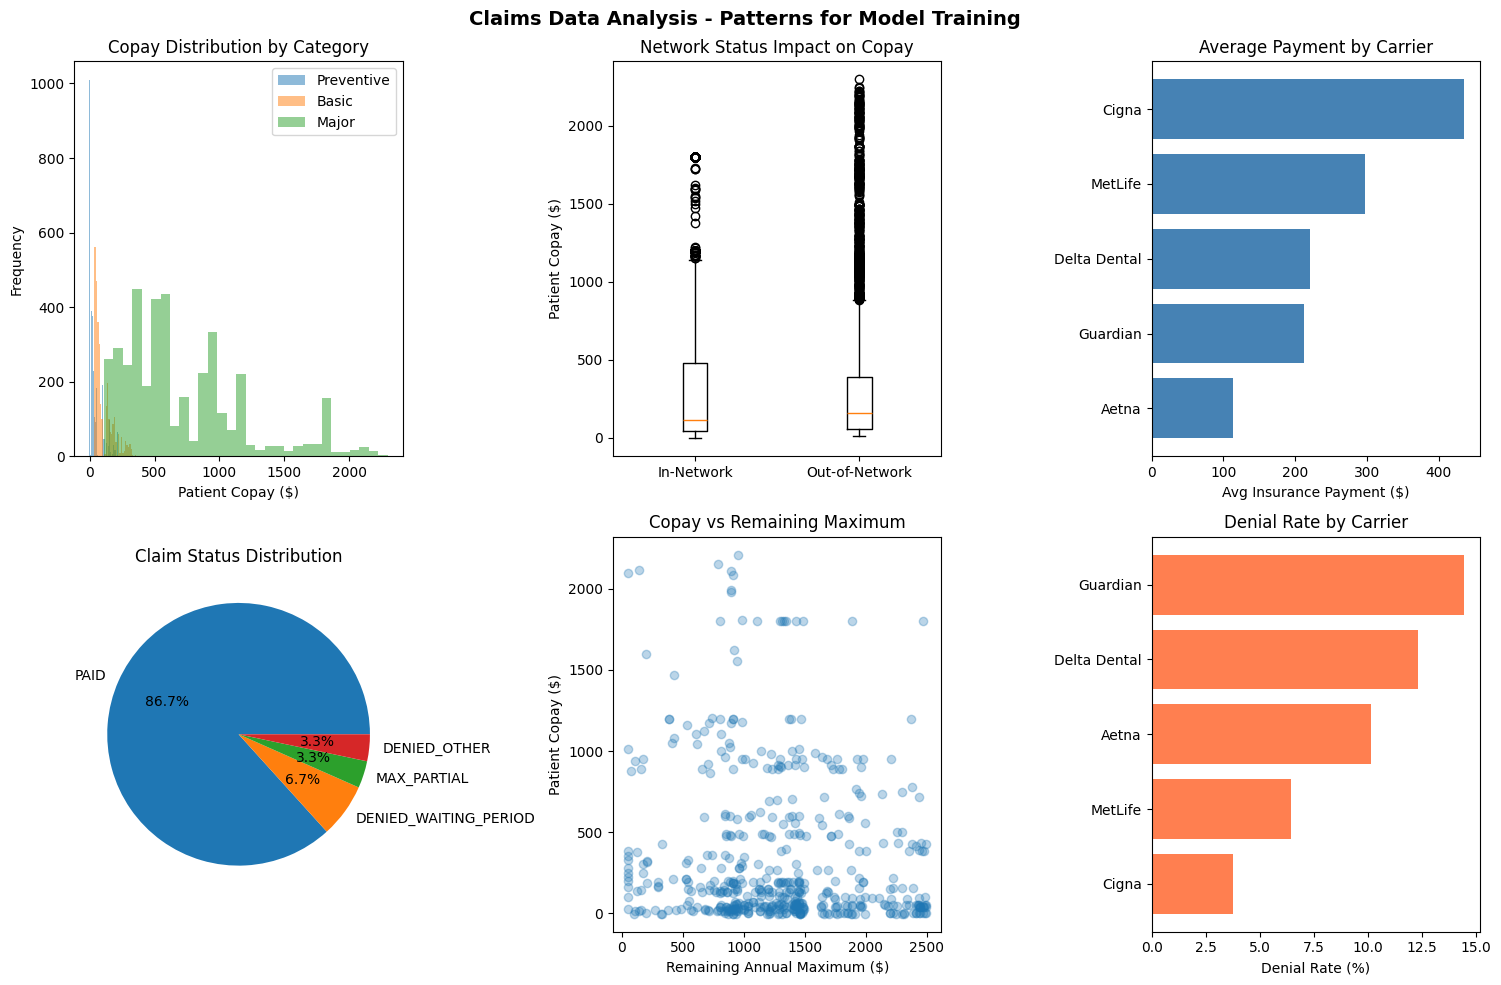


✓ Saved to gs://openbook-data-lake/figures/claims_analysis.png

KEY PATTERNS (what the model will learn):

Avg copay In-Network:     $307.52
Avg copay Out-of-Network: $361.58
OON Premium:              $54.06 (+17.6%)

Overall denial rate:      10.0%


In [9]:
# Analyze the claims data - visualize patterns the model will learn

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Claims Data Analysis - Patterns for Model Training', fontsize=14, fontweight='bold')

# 1. Copay distribution by category
ax1 = axes[0, 0]
for cat in ['preventive', 'basic', 'major']:
    data = claims_df[claims_df['procedure_category'] == cat]['patient_copay']
    ax1.hist(data, bins=30, alpha=0.5, label=cat.capitalize())
ax1.set_xlabel('Patient Copay ($)')
ax1.set_ylabel('Frequency')
ax1.set_title('Copay Distribution by Category')
ax1.legend()

# 2. In-network vs out-of-network copays
ax2 = axes[0, 1]
in_net = claims_df[claims_df['is_in_network'] == True]['patient_copay']
out_net = claims_df[claims_df['is_in_network'] == False]['patient_copay']
ax2.boxplot([in_net, out_net], labels=['In-Network', 'Out-of-Network'])
ax2.set_ylabel('Patient Copay ($)')
ax2.set_title('Network Status Impact on Copay')

# 3. Carrier payment patterns
ax3 = axes[0, 2]
carrier_avg = claims_df.groupby('carrier')['insurance_paid'].mean().sort_values()
ax3.barh(carrier_avg.index, carrier_avg.values, color='steelblue')
ax3.set_xlabel('Avg Insurance Payment ($)')
ax3.set_title('Average Payment by Carrier')

# 4. Claim status distribution
ax4 = axes[1, 0]
status_counts = claims_df['claim_status'].value_counts()
ax4.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%')
ax4.set_title('Claim Status Distribution')

# 5. Copay vs Remaining Maximum (shows max exhaustion pattern)
ax5 = axes[1, 1]
sample = claims_df[claims_df['annual_maximum'] > 0].sample(min(500, len(claims_df)))
ax5.scatter(sample['remaining_maximum'], sample['patient_copay'], alpha=0.3)
ax5.set_xlabel('Remaining Annual Maximum ($)')
ax5.set_ylabel('Patient Copay ($)')
ax5.set_title('Copay vs Remaining Maximum')

# 6. Denial rate by carrier
ax6 = axes[1, 2]
denial_rate = claims_df.groupby('carrier').apply(
    lambda x: (x['claim_status'].str.contains('DENIED')).mean() * 100
).sort_values()
ax6.barh(denial_rate.index, denial_rate.values, color='coral')
ax6.set_xlabel('Denial Rate (%)')
ax6.set_title('Denial Rate by Carrier')

plt.tight_layout()
plt.savefig('claims_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Save to GCS for README
blob = bucket.blob('figures/claims_analysis.png')
blob.upload_from_filename('claims_analysis.png')
print("\n✓ Saved to gs://openbook-data-lake/figures/claims_analysis.png")

# Print key statistics
print("\n" + "=" * 60)
print("KEY PATTERNS (what the model will learn):")
print("=" * 60)
print(f"\nAvg copay In-Network:     ${in_net.mean():.2f}")
print(f"Avg copay Out-of-Network: ${out_net.mean():.2f}")
print(f"OON Premium:              ${out_net.mean() - in_net.mean():.2f} (+{((out_net.mean()/in_net.mean())-1)*100:.1f}%)")
print(f"\nOverall denial rate:      {(claims_df['claim_status'].str.contains('DENIED')).mean()*100:.1f}%")

In [10]:
# Clean data and upload to GCS data lake

# Fix negative copays (carrier overpayment edge case)
claims_df['patient_copay'] = claims_df['patient_copay'].clip(lower=0)
claims_df['insurance_paid'] = claims_df['insurance_paid'].clip(lower=0)

print(f"Copay range after cleaning: ${claims_df['patient_copay'].min():.2f} - ${claims_df['patient_copay'].max():.2f}")

# Upload all datasets to GCS
datasets = {
    "raw/patients/patients.csv": patients_df,
    "raw/procedures/procedures.csv": PROCEDURES,
    "raw/insurance_plans/insurance_plans.csv": INSURANCE_PLANS,
    "raw/claims/claims.csv": claims_df,
    "raw/dental_office/dental_office.json": DENTAL_OFFICE,
}

for path, data in datasets.items():
    blob = bucket.blob(path)
    if path.endswith('.json'):
        blob.upload_from_string(json.dumps(data, indent=2))
    else:
        blob.upload_from_string(data.to_csv(index=False))
    print(f"✓ Uploaded gs://{BUCKET_NAME}/{path}")

print("\n" + "=" * 60)
print("DATA LAKE SUMMARY")
print("=" * 60)
print(f"  Patients:         {len(patients_df):,}")
print(f"  Insurance Plans:  {len(INSURANCE_PLANS)}")
print(f"  Procedures:       {len(PROCEDURES)}")
print(f"  Historical Claims: {len(claims_df):,}")
print(f"\n✓ Synthetic data generation complete")
print("✓ Ready for Dataflow feature engineering pipeline")

Copay range after cleaning: $0.00 - $2298.45
✓ Uploaded gs://openbook-data-lake/raw/patients/patients.csv
✓ Uploaded gs://openbook-data-lake/raw/procedures/procedures.csv
✓ Uploaded gs://openbook-data-lake/raw/insurance_plans/insurance_plans.csv
✓ Uploaded gs://openbook-data-lake/raw/claims/claims.csv
✓ Uploaded gs://openbook-data-lake/raw/dental_office/dental_office.json

DATA LAKE SUMMARY
  Patients:         1,000
  Insurance Plans:  6
  Procedures:       10
  Historical Claims: 10,000

✓ Synthetic data generation complete
✓ Ready for Dataflow feature engineering pipeline
